## Open Access to Data and Code

Ensuring open access to data and code is crucial for promoting transparency, reproducibility, and collaboration in scientific research. Here's how you can achieve this by leveraging repositories like [GitHub](https://github.com/) and [Hugging Face](https://huggingface.co/) to host code and data:

### Preparing Data and Code for Sharing:



#### Organize your data and code in a clear and well-documented structure.


Modern best practices for organizing Python code focus on improving readability, maintainability, scalability, and collaboration among developers. The following are some good practice recommendations.


**1. Follow PEP 8 guidelines:**



* Adhere to the [Python Enhancement Proposal (PEP) 8 style guide](https://peps.python.org/pep-0008/) for consistent and readable code formatting.
* Use tools like [flake8](https://flake8.pycqa.org/en/latest/) or [pylint](https://readthedocs.org/projects/pylint/) to automatically check code adherence to PEP 8 standards.

**2. Use descriptive naming:**



* Choose meaningful and descriptive names for variables, functions, classes, and modules to enhance code clarity.
* Follow the `lower_case` naming convention for variables and functions, `UpperCamelCase` for class names, and `ALL_CAPS` for constants.

**3. Organize code into modules and packages:**



* Break code into logical modules and packages to group related functionality together.
* Avoid cluttering the main script by moving reusable code into separate modules.
* Create a clear folder structure and use packages to organize related modules into hierarchical namespaces.

**4. Separation of concerns:**



* Follow the principle of separation of concerns by separating different aspects of functionality into distinct modules or classes.
* Divide code into functional parts (e.g., data pre-processing module, data loading module, model architecture module) to improve maintainability and scalability.

**5. Use docstrings and comments where necessary:**



* Include descriptive docstrings for modules, classes, functions, and methods to document their purpose, parameters, return values, and usage examples.
* Use tools like [Sphinx](https://www.sphinx-doc.org/en/master/) to generate documentation from docstrings automatically.
* Commenting code is also advisable when the code is very compact or hard to parse intuitively.

In the next cell, you'll find an example of using docstrings within a function to describe its purpose and that of the arguments required to execute it. Don't worry about understanding everything going on in the cell yet. Just notice how we can easily understand the role of the function. It's also worth noting that the code is well commented and the abides by the naming schematics we touched on earlier.

/Users/lillythomas/.pyenv/versions/wave/lib/python3.8/site-packages/stackstac/prepare.py:363: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


Sentinel-2 image loaded successfully


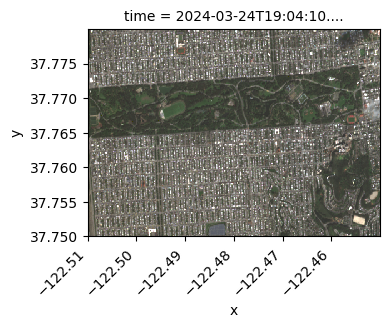

In [7]:
from datetime import datetime, timedelta
from shapely.geometry import Polygon, box
import matplotlib.pyplot as plt
import pystac_client
import stackstac
from rasterio.enums import Resampling
import xarray as xr

def read_sentinel_image_from_stac(stac_url: str, bbox: list, start_date: datetime, end_date: datetime, bands: list, max_cloud_cover: int, epsg: int) -> xr.DataArray:
    """
    Read the best Sentinel-2 image from the last two weeks based on cloud coverage 
    within the specified bounding box from a STAC catalog using pystac_client.

    Parameters:
        stac_url (str): The URL of the STAC catalog.
        bbox (list): Bounding box coordinates [west, south, east, north].
        start_date (datetime): Start date for temporal filtering.
        end_date (datetime): End date for temporal filtering.
        bands (list): List of bands to retrieve (e.g., ["red", "green", "blue"]).
        max_cloud_cover (int): Maximum cloud cover percentage allowed.
        epsg (int): EPSG code for the coordinate reference system.

    Returns:
        xr.DataArray: The Sentinel-2 image as an xarray DataArray.

    Raises:
        ValueError: If the request to the STAC API fails or if no suitable items are found.
    """
    try:
        # Define area of interest (AOI)
        area_of_interest = box(*bbox)

        # Connect to the STAC catalog
        catalog = pystac_client.Client.open(stac_url)

        # Search for Sentinel-2 items within the specified date range and AOI
        search = catalog.search(
            datetime=(start_date, end_date),
            intersects=area_of_interest,
            max_items=100,
            query={"eo:cloud_cover": {"lt": max_cloud_cover}},
        )
        items = search.get_all_items()

        if not items:
            raise ValueError("No suitable items found in the STAC catalog")

        # Choose the last item from the search results
        item = items[0]
        
        # Stack the assets (e.g., red, green, blue bands) into an xarray DataArray
        stack = stackstac.stack(
            item,
            bounds=bbox,
            snap_bounds=False,
            dtype="float32",
            epsg=epsg,
            rescale=False,
            fill_value=0,
            assets=bands,
            resampling=Resampling.nearest,
            xy_coords="center",
        )

        stack = stack.compute() 
        return stack

    except Exception as e:
        raise ValueError(f"Error accessing STAC catalog: {e}")

# Example usage:
STAC_URL = "https://earth-search.aws.element84.com/v1"  # AWS public Sentinel-2 STAC catalog
BBOX = [-122.51, 37.75, -122.45, 37.78]  # Bounding box for a subset of San Francisco
START_DATE = datetime.utcnow() - timedelta(weeks=2) # Last two weeks
END_DATE = datetime.utcnow() # Today
MAX_CLOUD_COVER = 80 # In percentage of pixels
BANDS = ["red", "green", "blue", "nir"] # Specific bands we want to use from Sentinel-2
EPSG = 4326

try:
    sentinel_image = read_sentinel_image_from_stac(STAC_URL, BBOX, START_DATE, END_DATE, 
                                                   BANDS, MAX_CLOUD_COVER, EPSG)
    print("Sentinel-2 image loaded successfully")
    # Plot the true color image
    plot = sentinel_image.sel(band=["red", "green", "blue"]).plot.imshow(row="time", rgb="band", vmin=0, vmax=5000)
    # Rotate x-axis labels diagonally
    plt.xticks(rotation=45, ha='right')
    plt.show()
except ValueError as ve:
    print("Error:", ve)


**6. Apply DRY (Don't Repeat Yourself) principle:**



* Avoid code duplication by extracting common functionality into reusable functions, classes, or modules.
* Encapsulate repetitive patterns into helper functions or utility modules to promote code reuse.

In general, we want to avoid re-writing a lot of [boiler-plate code](https://aws.amazon.com/what-is/boilerplate-code/#:~:text=Boilerplate%20code%20is%20computer%20language,minimal%20changes%20for%20different%20situations.) and instead abstract that to re-usable/re-purposable modules and/or use libraries that have already abstracted away a lot of low-level functionality. A good example of this for those who program in python and use satellite imagery is [rasterio](https://rasterio.readthedocs.io/en/stable/). This [open source](https://opensource.guide/) library abstracts away a lot of low-level image processing functionality into concise and wide-purpose functions that apply across many downstream applications.

**7. Follow Single Responsibility Principle (SRP):**



* Try to ensure that each module, class, or function has a single responsibility or purpose.
* Refactor complex functions or classes into smaller, focused units of functionality to improve readability and maintainability.

**8. Use configuration files:**

* Using configuration files to centralize parameters and constants is a common and effective practice in software development. It allows you to separate configuration details from code logic, making it easier to manage and update experiments or workflows without modifying the code itself. 
* Choose a configuration file format:
    * Common formats include [JSON](https://www.json.org/json-en.html), [YAML](https://yaml.org/), [INI](https://en.wikipedia.org/wiki/INI_file), and [TOML](https://toml.io/en/). Choose the format that best suits your project's requirements and preferences.
    
* Define configuration parameters:
    * Identify the parameters and constants in your code that are subject to change or customization, such as file paths, API endpoints, database connection details, argument flags, hyperparameters, logging settings, etc.

* Create a config file:
    * Create a dedicated configuration file (e.g., `config.json`, `config.yaml`) to store the configuration parameters.
    * Organize parameters hierarchically if needed, especially for complex configurations.
--------------------------------------------------
An example in YAML format for a simple image classification experiment could like the following:

```
model:
  type: CNNClassifier
  num_classes: 10
  pretrained: true
  backbone: resnet18

train:
  dataloader:
    batch_size: 64
    shuffle: true
    num_workers: 4

  optimizer:
    type: Adam
    lr: 0.001
    weight_decay: 0.0001

  scheduler:
    type: StepLR
    step_size: 7
    gamma: 0.1

  epochs: 20

  checkpoint_path: checkpoints/

  log_interval: 100

test:
  dataloader:
    batch_size: 64
    num_workers: 4

  checkpoint: checkpoints/best_model.pth
```
--------------------------------------------
* Load configuration in code:
    * Write code to load the configuration file and parse its contents into a data structure (e.g., dictionary, object) that can be accessed programmatically.
    * Use libraries like json, yaml, or configparser (for INI files) in Python to handle parsing and loading config files.
    * This is an area where boiler-plate code can and should be reduced. There are many libraries that help in loading details from configuration files.
    
**9. Clean and anonymize data, removing any sensitive or personally identifiable information:**
* Remove API keys, passwords or other forms of information that should not be shared. Use configurable arguments that one would supply at runtime instead.

**10. Work from branches:**

* Working from change-specific [branches](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/proposing-changes-to-your-work-with-pull-requests/about-branches) in GitHub instead of directly in the main branch is important for several reasons:

    * Isolation of changes: Branches allow developers to isolate their changes from the main codebase until they are ready to be merged. This prevents incomplete or experimental ("work-in-progress" or "draft") code from affecting the stability of the main branch.

    * Collaboration: Branches facilitate collaboration among team members by enabling them to work on different features or fixes simultaneously without interfering with each other's work. Each developer can have their own branch to work on a specific task.

    * Code review: By working on branches, developers can create pull requests (PRs) to propose changes to the main branch. PRs provide an opportunity for code review, where team members can provide feedback, suggestions, and identify potential issues before merging the changes into the main branch.

    * Version control: Branches serve as a way to manage different versions or variants of the codebase. They allow developers to experiment with new features or bug fixes without affecting the main branch, and they can easily switch between branches to work on different tasks.

**11. Contribute quality pull requests:**

To consolidate the changes made in a dedicated change-specific branch to the main branch, it is best practice to submit a quality [pull request](https://docs.github.com/en/pull-requests/collaborating-with-pull-requests/proposing-changes-to-your-work-with-pull-requests/about-pull-requests) (PR) such that other collaborators can vet the changes and ensure they exhibit expected behavior and don't introduce any breaking patterns.

* To make a good pull request in GitHub, consider the following best practices:

    * Create a descriptive title: The title should accurately summarize the purpose of the PR, making it easy for reviewers to understand what changes are being proposed.

    * Provide a clear description: Write a detailed description of the changes included in the PR, explaining the problem being addressed and the solution implemented. Include any relevant context, background information, or dependencies.

    * Include related issues or pull requests: If the PR is related to specific issues or other PRs, reference them in the description using GitHub's linking syntax (e.g., `#issue_number` or `GH-PR-number`).

    * Break down large changes: If the PR includes a significant number of changes or multiple unrelated changes, consider breaking it down into smaller, more manageable PRs. This makes the review process easier and allows for better focus on individual changes.

    * Follow coding standards and conventions: Ensure that the code adheres to the project's coding standards, style guidelines, and best practices. Consistency in formatting, naming conventions, and code organization is important for readability and maintainability.

    * Include tests: If applicable, include tests to verify the correctness and functionality of the changes. Test coverage helps ensure that the code behaves as expected and reduces the risk of introducing regressions.

    * Review your own changes: Before submitting the PR, review your own changes to check for errors, typos, or any unintended side effects. This helps streamline the review process and demonstrates attention to detail.

    * Solicit feedback: If you're unsure about any aspect of the changes, don't hesitate to ask for feedback from colleagues or maintainers. Collaboration and communication are key to producing high-quality code.


**12. Use version control:**



* Utilize version control systems like Git to track changes, collaborate with other developers, and manage code history.
* Follow branching and merging strategies (e.g., [GitFlow](https://docs.aws.amazon.com/prescriptive-guidance/latest/choosing-git-branch-approach/gitflow-branching-strategy.html) to organize development workflow and facilitate collaboration.
* Include configuration files in version control to track changes and ensure consistency across development environments.
* Document the purpose and usage of each configuration parameter within the config file or accompanying documentation.

**13. Write unit tests:**



* Implement unit tests using frameworks like [unittest](https://docs.python.org/3/library/unittest.html) or [pytest](https://docs.pytest.org/en/8.0.x/) to verify the correctness of individual components and prevent regressions.
* Aim for high test coverage to ensure comprehensive testing of code functionality.


**14. Use virtual environments:**



* Create isolated virtual environments using tools like [virtualenv](https://virtualenv.pypa.io/en/latest/) or [conda](https://docs.conda.io/en/latest/) to manage project dependencies and avoid conflicts between packages.

**15. Document dependencies:**



* Document project dependencies explicitly by maintaining a `requirements.txt` or `environment.yml` file to specify project or package versions.
* Use dependency management tools like [pip](https://pypi.org/project/pip/) or [conda](https://docs.conda.io/en/latest/) to install and manage dependencies consistently.

**16. Automate testing and CI/CD:**



* Set up automated testing pipelines using continuous integration (CI) tools like [GitHub Actions](https://docs.github.com/en/actions) to run tests automatically on code changes.
* Implement continuous delivery/deployment (CD) pipelines to automate the process of building, testing, and deploying code changes to production environments.

**17. Code reviews and peer feedback:**



* Conduct regular PR reviews to provide feedback, identify potential issues, and ensure adherence to coding standards and best practices.
* Encourage collaboration and knowledge sharing among team members through constructive peer reviews.


### Using GitHub for version control and collaboration:



* GitHub is a popular platform for version control and collaborative development.
* Create a GitHub repository to host your code, scripts, and related documentation.
* Commit your changes regularly to track the evolution of your codebase over time.
* (Re-emphasizing) use of branches to work on new features or experimental changes so as not to affect the main codebase.
* Leverage GitHub's issue tracking and project management features to coordinate tasks and communicate with collaborators.

**Sharing data on GitHub**:


* Occasionally, you might want to store small-sized datasets directly within your GitHub repository (e.g. for unit tests).
* For larger datasets, consider providing download links to external storage platforms like [Amazon S3](https://aws.amazon.com/pm/serv-s3/?gclid=Cj0KCQjwzZmwBhD8ARIsAH4v1gUtsUE7VBaEAD5huvuIsFi7825Zici35fHF9N2CMlK3c1QW_X6_ttcaAoddEALw_wcB&trk=fecf68c9-3874-4ae2-a7ed-72b6d19c8034&sc_channel=ps&ef_id=Cj0KCQjwzZmwBhD8ARIsAH4v1gUtsUE7VBaEAD5huvuIsFi7825Zici35fHF9N2CMlK3c1QW_X6_ttcaAoddEALw_wcB:G:s&s_kwcid=AL!4422!3!536452728638!e!!g!!amazon%20s3!11204620052!112938567994) or [Google Cloud Storage](https://cloud.google.com/storage).
* Include a [README](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-readmes) file in your repository that provides information about the dataset, its format, and any preprocessing steps required.

**Using Hugging Face for model and dataset sharing**:



* [Hugging Face](https://huggingface.co/) is a platform that specializes in hosting and sharing machine learning models and datasets.
* Use Hugging Face's datasets library to upload and share your datasets with the community.
* Similarly, you can use the model hub to host and share your trained models, along with associated code for fine-tuning or inference.

**Choosing Open-Access Licenses**:



* Selecting the appropriate open-access license is essential for defining how others can use, modify, and redistribute your code and data.
* Common open-access licenses include [MIT License](https://tlo.mit.edu/understand-ip/exploring-mit-open-source-license-comprehensive-guide), [Apache License](https://www.apache.org/licenses/LICENSE-2.0), [GNU General Public License (GPL)](https://www.gnu.org/licenses/gpl-3.0.en.html), and [Creative Commons licenses](https://creativecommons.org/share-your-work/cclicenses/).
* Include a LICENSE file in your repository that clearly specifies the terms and conditions under which your code and data can be used.

**Documenting Usage and Citation**:



* Provide clear instructions on how others can use your code and data, including installation steps, dependencies, and examples.
* Encourage users to cite your work properly by providing citation information and [DOI (Digital Object Identifier)](https://www.doi.org/) links where applicable.
* Include a [CONTRIBUTING.md file](https://mozillascience.github.io/working-open-workshop/contributing/#:~:text=A%20CONTRIBUTING.md%20file%2C%20in,md).) in your repository that outlines guidelines for contributing to and citing your project.